<a href="https://colab.research.google.com/github/johnnydhnguyen/twitch-predictive-tool/blob/main/Twitch_predictive_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ARDRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.svm import NuSVR
from numpy import mean
warnings.simplefilter('ignore')
from sklearn.pipeline import make_pipeline

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.7 MB/s 


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 10.3 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 209 kB 57.3 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 112 kB 47.7 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 147 kB 44.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b3ad1b43b10c34e3343bb182805af2bfad46b2b0dc3f131b73033bfaae2a12a1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import shap
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing data

In [ ]:
df_full = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Twitch_game_data.csv',encoding='cp1252')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              14400 non-null  int64  
 1   Game              14399 non-null  object 
 2   Month             14400 non-null  int64  
 3   Year              14400 non-null  int64  
 4   Hours_watched     14400 non-null  int64  
 5   Hours_Streamed    14400 non-null  object 
 6   Peak_viewers      14400 non-null  int64  
 7   Peak_channels     14400 non-null  int64  
 8   Streamers         14400 non-null  int64  
 9   Avg_viewers       14400 non-null  int64  
 10  Avg_channels      14400 non-null  int64  
 11  Avg_viewer_ratio  14400 non-null  float64
dtypes: float64(1), int64(9), object(2)
memory usage: 1.3+ MB


In [ ]:
#data cleaning original file

df_full['Hours_Streamed']=df_full['Hours_Streamed'].str.replace(' hours','')
df_full['Hours_Streamed']=df_full['Hours_Streamed'].astype('int64')

df_full['Month']=df_full['Month'].astype('object')
df_full['Year']=df_full['Year'].astype('object')

#df_full['Month_Year'] = df_full['Month'].str + '_' + df_full['Year'].str

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              14400 non-null  int64  
 1   Game              14399 non-null  object 
 2   Month             14400 non-null  object 
 3   Year              14400 non-null  object 
 4   Hours_watched     14400 non-null  int64  
 5   Hours_Streamed    14400 non-null  int64  
 6   Peak_viewers      14400 non-null  int64  
 7   Peak_channels     14400 non-null  int64  
 8   Streamers         14400 non-null  int64  
 9   Avg_viewers       14400 non-null  int64  
 10  Avg_channels      14400 non-null  int64  
 11  Avg_viewer_ratio  14400 non-null  float64
dtypes: float64(1), int64(8), object(3)
memory usage: 1.3+ MB


In [ ]:
#creating year_month column original file

Year_Month=[]

for i,row in df_full[['Year','Month']].iterrows():
    if (row[1] < 10):
        m_y = str(row[0])+'_0'+str(row[1])
        Year_Month.append(m_y)
    else:
        m_y = str(row[0])+'_'+str(row[1])
        Year_Month.append(m_y)
    
df_full['Year_Month'] = Year_Month

In [ ]:
df_full['Avg_viewers'] = df_full['Avg_viewers'].clip(upper=205000)

df_full['Peak_channels'] = df_full['Peak_channels'].clip(upper=20500)

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              14400 non-null  int64  
 1   Game              14399 non-null  object 
 2   Month             14400 non-null  object 
 3   Year              14400 non-null  object 
 4   Hours_watched     14400 non-null  int64  
 5   Hours_Streamed    14400 non-null  int64  
 6   Peak_viewers      14400 non-null  int64  
 7   Peak_channels     14400 non-null  int64  
 8   Streamers         14400 non-null  int64  
 9   Avg_viewers       14400 non-null  int64  
 10  Avg_channels      14400 non-null  int64  
 11  Avg_viewer_ratio  14400 non-null  float64
 12  Year_Month        14400 non-null  object 
dtypes: float64(1), int64(8), object(4)
memory usage: 1.4+ MB


In [ ]:
df_full.tail()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Year_Month
14395,196,Garry's Mod,12,2021,630902,21753,24951,99,3537,849,29,29.00,2021_12
14396,197,Call of Duty: Black Ops Cold War,12,2021,622497,223641,26559,654,25366,837,300,2.78,2021_12
14397,198,Noita,12,2021,620983,13935,27826,41,1961,835,18,44.56,2021_12
14398,199,Pro Soccer Online,12,2021,619859,606,36182,20,84,834,0,1022.87,2021_12
14399,200,Pok<U+00E9>mon Sword/Shield,12,2021,615725,42291,8878,106,4411,828,56,14.56,2021_12


In [ ]:
df_full.describe()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,14400.00000,1.440000e+04,1.440000e+04,1.440000e+04,14400.000000,1.440000e+04,14400.000000,14400.000000,14400.000000
mean,100.50000,4.782448e+06,1.571197e+05,5.509512e+04,539.047083,1.722478e+04,6343.397431,214.859097,81.874403
std,57.73631,1.667895e+07,5.428111e+05,1.329134e+05,1665.926602,5.453153e+04,20253.940160,743.850310,368.878411
min,1.00000,8.981100e+04,1.900000e+01,4.410000e+02,1.000000,0.000000e+00,120.000000,0.000000,1.950000
25%,50.75000,3.680565e+05,1.221250e+04,8.352500e+03,51.750000,1.479500e+03,504.000000,16.000000,16.120000
50%,100.50000,8.198695e+05,3.163800e+04,2.016950e+04,122.000000,4.126000e+03,1125.000000,43.000000,29.160000
75%,150.25000,2.295376e+06,8.871850e+04,4.598150e+04,318.000000,1.071425e+04,3158.000000,121.000000,57.795000
max,200.00000,3.445520e+08,1.024570e+07,3.123208e+06,20500.000000,1.013029e+06,205000.000000,13789.000000,13601.870000


In [ ]:
#DATA SELECTION ORIGINAL FILE


#list variables
Shooters_Tactical = ['Counter-Strike: Global Offensive','Tom Clancy\'s Rainbow Six Siege','Overwatch','VALORANT','Call Of Duty: Modern Warfare']
Shooters_Battle_Royale = ['Apex Legends', 'PLAYERUNKNOWN\'S BATTLEGROUNDS','Call of Duty: Warzone','Fortnite']

#dataframe tacticl shooters
df_Tactical = df_full[df_full['Game'].isin(Shooters_Tactical)].copy()


#dataframe battle royale shooters
df_Battle_Royale = df_full[df_full['Game'].isin(Shooters_Battle_Royale)].copy()

In [ ]:
df_Tactical

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Year_Month
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,2016_01
15,16,Tom Clancy's Rainbow Six Siege,1,2016,4866039,242134,25742,694,42244,6549,325,20.10,2016_01
201,2,Counter-Strike: Global Offensive,2,2016,44933218,754901,235027,2097,106074,64652,1086,59.52,2016_02
212,13,Overwatch,2,2016,4735263,68029,94851,546,7075,6813,97,69.61,2016_02
217,18,Tom Clancy's Rainbow Six Siege,2,2016,3237323,219127,28240,628,36759,4658,315,14.77,2016_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14202,3,VALORANT,12,2021,98306478,2812461,1047665,6019,249067,132310,3785,34.95,2021_12
14209,10,Counter-Strike: Global Offensive,12,2021,45401155,914766,524450,2485,94162,61105,1231,49.63,2021_12
14233,34,Overwatch,12,2021,8003500,477729,55187,1087,50636,10771,642,16.75,2021_12
14235,36,Tom Clancy's Rainbow Six Siege,12,2021,7688187,567817,54163,1586,69242,10347,764,13.54,2021_12


In [ ]:
(df_Tactical['Game'] == 'Counter-Strike: Global Offensive')

1         True
15       False
201       True
212      False
217      False
         ...  
14202    False
14209     True
14233    False
14235    False
14270    False
Name: Game, Length: 251, dtype: bool

In [ ]:
#Appending publisher name to each row tactical

Pub_Tactical=[]


#tactical publisher append
for i,row in pd.DataFrame(df_Tactical['Game']).iterrows():
    if (row[0] == 'Counter-Strike: Global Offensive'):
        publisher = 'Valve'
        Pub_Tactical.append(publisher)
        
    elif (row[0] == 'Tom Clancy\'s Rainbow Six Siege'):
        publisher = 'Ubisoft'
        Pub_Tactical.append(publisher)
        
    elif (row[0] == 'Overwatch'):
        publisher = 'Blizzard'
        Pub_Tactical.append(publisher)
    
    elif (row[0] == 'VALORANT'):
        publisher = 'Riot'
        Pub_Tactical.append(publisher)
    
    elif (row[0] == 'Call Of Duty: Modern Warfare'):
        publisher = 'Activision'
        Pub_Tactical.append(publisher)


df_Tactical['Publisher'] = Pub_Tactical

    

In [ ]:
#Appending publisher name to each row BR


Pub_Battle = []

#Battle royale publisher append

for i,row in pd.DataFrame(df_Battle_Royale['Game']).iterrows():
    if (row[0] == 'Apex Legends'):
        publisher = 'Respawn'
        Pub_Battle.append(publisher)
        
    elif (row[0] == 'PLAYERUNKNOWN\'S BATTLEGROUNDS'):
        publisher = 'Krafton'
        Pub_Battle.append(publisher)
        
    elif (row[0] == 'Call of Duty: Warzone'):
        publisher = 'Activision'
        Pub_Battle.append(publisher)
    
    elif (row[0] == 'Fortnite'):
        publisher = 'Epic Games'
        Pub_Battle.append(publisher)
        
df_Battle_Royale['Publisher'] = Pub_Battle

In [ ]:
df_Battle_Royale

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Year_Month,Publisher
1729,130,PLAYERUNKNOWN'S BATTLEGROUNDS,9,2016,163045,743,40509,76,214,226,1,219.44,2016_09,Krafton
2050,51,PLAYERUNKNOWN'S BATTLEGROUNDS,11,2016,858194,8909,42520,232,1439,1193,12,96.33,2016_11,Krafton
2273,74,PLAYERUNKNOWN'S BATTLEGROUNDS,12,2016,646304,3771,32673,117,627,869,5,171.39,2016_12,Krafton
2634,35,PLAYERUNKNOWN'S BATTLEGROUNDS,2,2017,2079661,12467,85949,368,2022,3099,18,166.81,2017_02,Krafton
2804,5,PLAYERUNKNOWN'S BATTLEGROUNDS,3,2017,24877888,289011,150320,1629,26794,33483,388,86.08,2017_03,Krafton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14007,8,Fortnite,11,2021,50178082,3235937,363096,7961,329946,69788,4500,15.51,2021_11,Epic Games
14010,11,Call of Duty: Warzone,11,2021,35895578,1854733,262685,6008,121583,49924,2579,19.35,2021_11,Activision
14205,6,Fortnite,12,2021,67039763,4833376,1270408,20500,499414,90228,6505,13.87,2021_12,Epic Games
14207,8,Call of Duty: Warzone,12,2021,52562076,2234477,456502,9068,133039,70743,3007,23.52,2021_12,Activision


#Importing websearch data

In [ ]:
#IMPORTING BATTLE ROYALE WEBSEARCH AND CLEANING


Publishers_Battle_Royale=['Respawn','Krafton','Activision','Epic Games']
Bat_websearch_game =['Apex Legends','PLAYERUNKNOWN\'S BATTLEGROUNDS','Call of Duty Warzone','Fortnite']

df_web_bat = pd.DataFrame(columns=['Year_Month'])

for pub,game in zip(Publishers_Battle_Royale,Bat_websearch_game):
    print(pub)
    print(game)
    df_tmp = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Google Trends/Websearch/Battle Royale/{}/multiTimeline_{}_Websearch.csv'.format(pub,game))
    Year_Month=[]
    
    df_tmp['Year'] = pd.DatetimeIndex(df_tmp['Week']).year
    df_tmp['Month'] = pd.DatetimeIndex(df_tmp['Week']).month
    
    for i,row in df_tmp[['Year','Month']].iterrows():
        if (row[1] < 10):
            m_y = str(row[0])+'_0'+str(row[1])
            Year_Month.append(m_y)
        else:
            m_y = str(row[0])+'_'+str(row[1])
            Year_Month.append(m_y)

    df_tmp['Year_Month'] = Year_Month
    df_tmp.drop(columns=['Year','Month','Week'],inplace=True)
    
    df_web_bat = pd.merge(df_web_bat,df_tmp,how='outer',on='Year_Month')

df_web_bat.fillna(0,inplace=True)

Respawn
Apex Legends
Krafton
PLAYERUNKNOWN'S BATTLEGROUNDS
Activision
Call of Duty Warzone
Epic Games
Fortnite


In [ ]:
df_web_bat.columns

Index(['Apex Legends', 'Year_Month', 'PLAYERUNKNOWN'S BATTLEGROUNDS',
       'Call of Duty: Warzone', 'Fortnite'],
      dtype='object')

In [ ]:
#adding _web to websearch battle royale
df_web_bat_columns = []

for col in df_web_bat.columns:
    if col == 'Year_Month':
        col = 'Year_Month'
        df_web_bat_columns.append(col)
    else:
        col = f'{col}_web'
        df_web_bat_columns.append(col)  
    

In [ ]:
df_web_bat_columns

['Apex Legends_web',
 'Year_Month',
 "PLAYERUNKNOWN'S BATTLEGROUNDS_web",
 'Call of Duty: Warzone_web',
 'Fortnite_web']

In [ ]:
df_web_bat.columns = df_web_bat_columns

In [ ]:
df_web_bat.columns

Index(['Apex Legends_web', 'Year_Month', 'PLAYERUNKNOWN'S BATTLEGROUNDS_web',
       'Call of Duty: Warzone_web', 'Fortnite_web'],
      dtype='object')

In [ ]:
#grouping battle royale web data by year_month

df_web_bat = df_web_bat.groupby('Year_Month').max()

In [ ]:
#IMPORTING TACTICAL WEBSEARCH AND CLEANING

Publishers_Tactical=['Valve', 'Ubisoft', 'Blizzard', 'Riot', 'Activision']
Tac_websearch_game =['Counter-Strike Global Offensive', 'Tom Clancy\'s Rainbow Six Siege', 'Overwatch','VALORANT','Call Of Duty Modern Warfare']


df_web_tac = pd.DataFrame(columns=['Year_Month'])

for pub,game in zip(Publishers_Tactical,Tac_websearch_game):
    print(pub)
    print(game)
    df_tmp = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Google Trends/Websearch/Tactical/{}/multiTimeline_{}_Websearch.csv'.format(pub,game))
    Year_Month=[]
    
    df_tmp['Year'] = pd.DatetimeIndex(df_tmp['Week']).year
    df_tmp['Month'] = pd.DatetimeIndex(df_tmp['Week']).month
    
    for i,row in df_tmp[['Year','Month']].iterrows():
        if (row[1] < 10):
            m_y = str(row[0])+'_0'+str(row[1])
            Year_Month.append(m_y)
        else:
            m_y = str(row[0])+'_'+str(row[1])
            Year_Month.append(m_y)

    df_tmp['Year_Month'] = Year_Month
    df_tmp.drop(columns=['Year','Month','Week'],inplace=True)
    
    df_web_tac = pd.merge(df_web_tac,df_tmp,how='outer',on='Year_Month')

df_web_tac.fillna(0,inplace=True)


Valve
Counter-Strike Global Offensive
Ubisoft
Tom Clancy's Rainbow Six Siege
Blizzard
Overwatch
Riot
VALORANT
Activision
Call Of Duty Modern Warfare


In [ ]:
#adding _web to websearch tactical

df_web_tac_columns = []

for col in df_web_tac.columns:
    if col == 'Year_Month':
        col = 'Year_Month'
        df_web_tac_columns.append(col)
    else:
        col = f'{col}_web'
        df_web_tac_columns.append(col)  

df_web_tac.columns = df_web_tac_columns

In [ ]:
df_web_tac

,Counter-Strike: Global Offensive_web,Year_Month,Tom Clancy's Rainbow Six Siege_web,Overwatch_web,Valorant_web,Call of Duty: Modern Warfare_web
0,74,2017_05,32,100,0.0,0.0
1,74,2017_06,48,83,0.0,0.0
2,74,2017_06,48,74,0.0,0.0
3,74,2017_06,48,70,0.0,0.0
4,74,2017_06,48,62,0.0,0.0
...,...,...,...,...,...,...
52052,0,2022_05,0,0,44.0,0.0
52053,0,2022_05,0,0,0.0,3.0
52054,0,2022_05,0,0,0.0,3.0
52055,0,2022_05,0,0,0.0,3.0


#importing youtube data

In [ ]:
#grouping tactical web data by year_month

df_web_tac = df_web_tac.groupby('Year_Month').max()

In [ ]:
#IMPORTING TACTICAL YOUTUBE AND CLEANING

Publishers_Tactical=['Valve', 'Ubisoft', 'Blizzard', 'Riot', 'Activision']
Tac_YT_game =['Counter-Strike Global Offensive', 'Tom Clancy\'s Rainbow Six Siege', 'Overwatch','VALORANT','Call Of Duty Modern Warfare']


df_YT_tac = pd.DataFrame(columns=['Year_Month'])

for pub,game in zip(Publishers_Tactical,Tac_YT_game):
    print(pub)
    print(game)
    df_tmp = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Google Trends/YoutubeSearch/Tactical/{}/multiTimeline_{}_YT.csv'.format(pub,game))
    Year_Month=[]
    
    df_tmp['Year'] = pd.DatetimeIndex(df_tmp['Week']).year
    df_tmp['Month'] = pd.DatetimeIndex(df_tmp['Week']).month
    
    for i,row in df_tmp[['Year','Month']].iterrows():
        if (row[1] < 10):
            m_y = str(row[0])+'_0'+str(row[1])
            Year_Month.append(m_y)
        else:
            m_y = str(row[0])+'_'+str(row[1])
            Year_Month.append(m_y)

    df_tmp['Year_Month'] = Year_Month
    df_tmp.drop(columns=['Year','Month','Week'],inplace=True)
    
    df_YT_tac = pd.merge(df_YT_tac,df_tmp,how='outer',on='Year_Month')

df_YT_tac.fillna(0,inplace=True)


Valve
Counter-Strike Global Offensive
Ubisoft
Tom Clancy's Rainbow Six Siege
Blizzard
Overwatch
Riot
VALORANT
Activision
Call Of Duty Modern Warfare


In [ ]:
#adding _YT to youtube battle royale
df_YT_tac_columns = []

for col in df_YT_tac.columns:
    if col == 'Year_Month':
        col = 'Year_Month'
        df_YT_tac_columns.append(col)
    else:
        col = f'{col}_YT'
        df_YT_tac_columns.append(col)

df_YT_tac.columns = df_YT_tac_columns
    

In [ ]:
df_YT_tac

,Counter-Strike: Global Offensive_YT,Year_Month,Tom Clancy's Rainbow Six Siege_YT,Overwatch_YT,Valorant_YT,Call of Duty: Modern Warfare_YT
0,90,2017_05,42,100,0.0,0.0
1,88,2017_06,41,95,0.0,0.0
2,88,2017_06,41,83,0.0,0.0
3,88,2017_06,41,79,0.0,0.0
4,88,2017_06,41,67,0.0,0.0
...,...,...,...,...,...,...
53064,0,2022_05,0,0,57.0,0.0
53065,0,2022_05,0,0,0.0,6.0
53066,0,2022_05,0,0,0.0,5.0
53067,0,2022_05,0,0,0.0,5.0


In [ ]:
#grouping tactical YT data by year_month
df_YT_tac = df_YT_tac.groupby('Year_Month').max()

In [ ]:
df_YT_tac

,Counter-Strike: Global Offensive_YT,Tom Clancy's Rainbow Six Siege_YT,Overwatch_YT,Valorant_YT,Call of Duty: Modern Warfare_YT
Year_Month,,,,,
2017_05,90,42,100,0.0,0.0
2017_06,94,43,95,0.0,0.0
2017_07,100,54,93,0.0,0.0
2017_08,51,95,94,0.0,0.0
2017_09,46,86,61,0.0,0.0
...,...,...,...,...,...
2022_01,17,16,9,76.0,6.0
2022_02,16,18,8,72.0,6.0
2022_03,15,15,8,60.0,6.0


In [ ]:
#IMPORTING BATTLE ROYALE YT AND CLEANING

Publishers_Battle_Royale=['Respawn','Krafton','Activision','Epic Games']
Bat_YT_game =['Apex Legends','PLAYERUNKNOWN\'S BATTLEGROUNDS','Call of Duty Warzone','Fortnite']

df_YT_bat = pd.DataFrame(columns=['Year_Month'])


for pub,game in zip(Publishers_Battle_Royale,Bat_YT_game):
    print(pub)
    print(game)
    df_tmp = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Google Trends/YoutubeSearch/Battle Royale/{}/multiTimeline_{}_YT.csv'.format(pub,game))
    Year_Month=[]
    
    df_tmp['Year'] = pd.DatetimeIndex(df_tmp['Week']).year
    df_tmp['Month'] = pd.DatetimeIndex(df_tmp['Week']).month
    
    for i,row in df_tmp[['Year','Month']].iterrows():
        if (row[1] < 10):
            m_y = str(row[0])+'_0'+str(row[1])
            Year_Month.append(m_y)
        else:
            m_y = str(row[0])+'_'+str(row[1])
            Year_Month.append(m_y)

    df_tmp['Year_Month'] = Year_Month
    df_tmp.drop(columns=['Year','Month','Week'],inplace=True)
    
    df_YT_bat = pd.merge(df_YT_bat,df_tmp,how='outer',on='Year_Month')

df_YT_bat.fillna(0,inplace=True)

Respawn
Apex Legends
Krafton
PLAYERUNKNOWN'S BATTLEGROUNDS
Activision
Call of Duty Warzone
Epic Games
Fortnite


In [ ]:
#adding _YT to youtube battle royale
df_YT_bat_columns = []

for col in df_YT_bat.columns:
    if col == 'Year_Month':
        col = 'Year_Month'
        df_YT_bat_columns.append(col)
    else:
        col = f'{col}_YT'
        df_YT_bat_columns.append(col)  

df_YT_bat.columns = df_YT_bat_columns

In [ ]:
#grouping battle royale YT data by year_month

df_YT_bat = df_YT_bat.groupby('Year_Month').max()

#importing tournament data

In [ ]:
#IMPORTING TACTICAL TOURNAMENT AND CLEANING

Publishers_Tactical=['Valve', 'Ubisoft', 'Blizzard', 'Riot', 'Activision']
Tac_tournament_game =['Counter-Strike Global Offensive', 'Tom Clancy\'s Rainbow Six Siege', 'Overwatch','VALORANT','Call Of Duty Modern Warfare']


df_tournament_tac = pd.DataFrame(columns=['Year_Month'])

for pub,game in zip(Publishers_Tactical,Tac_tournament_game):
    print(pub)
    print(game)
    df_tmp = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/Tournament dates/Tactical/{}/{}_tournament.csv'.format(pub,game))
    Year_Month=[]
    
    df_tmp['Year'] = pd.DatetimeIndex(df_tmp['Date']).year
    df_tmp['Month'] = pd.DatetimeIndex(df_tmp['Date']).month
    
    for i,row in df_tmp[['Year','Month']].iterrows():
        if (row[1] < 10):
            m_y = str(row[0])+'_0'+str(row[1])
            Year_Month.append(m_y)
        else:
            m_y = str(row[0])+'_'+str(row[1])
            Year_Month.append(m_y)

    df_tmp['Year_Month'] = Year_Month
    df_tmp[f'Tac_tournament_{game}'] = game
    df_tmp.drop(columns=['Year','Month','Date','Tournament'],inplace=True)
    
    df_tournament_tac = pd.concat([df_tournament_tac,df_tmp],axis=0)

df_web_tac.fillna(0,inplace=True)
df_tournament_tac.to_csv(r'C:\Users\Johnny\Documents\Risk_analysis_tool_esports\Tournament dates\Test_dataframe\test_data.csv')

Valve
Counter-Strike Global Offensive
Ubisoft
Tom Clancy's Rainbow Six Siege
Blizzard
Overwatch
Riot
VALORANT
Activision
Call Of Duty Modern Warfare


In [ ]:
df_tournament_tac = df_tournament_tac.groupby('Year_Month').count()

In [ ]:
df_tournament_tac

,Tac_tournament_Counter-Strike Global Offensive,Tac_tournament_Tom Clancy's Rainbow Six Siege,Tac_tournament_Overwatch,Tac_tournament_VALORANT,Tac_tournament_Call Of Duty Modern Warfare
Year_Month,,,,,
2016_09,1,0,0,0,0
2016_10,3,0,0,0,0
2016_11,3,0,0,0,0
2016_12,1,0,0,0,0
2017_01,1,0,1,0,0
...,...,...,...,...,...
2021_10,3,3,0,3,0
2021_11,1,1,0,0,0
2021_12,2,0,0,1,0


In [ ]:
df_Tactical['Game'].value_counts()

Counter-Strike: Global Offensive    72
Tom Clancy's Rainbow Six Siege      72
Overwatch                           71
VALORANT                            21
Call Of Duty: Modern Warfare        15
Name: Game, dtype: int64

In [ ]:
df_Battle_Royale['Game'].value_counts()

PLAYERUNKNOWN'S BATTLEGROUNDS    55
Fortnite                         54
Apex Legends                     35
Call of Duty: Warzone            29
Name: Game, dtype: int64

In [ ]:
df_Battle_Royale

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Year_Month,Publisher
1729,130,PLAYERUNKNOWN'S BATTLEGROUNDS,9,2016,163045,743,40509,76,214,226,1,219.44,2016_09,Krafton
2050,51,PLAYERUNKNOWN'S BATTLEGROUNDS,11,2016,858194,8909,42520,232,1439,1193,12,96.33,2016_11,Krafton
2273,74,PLAYERUNKNOWN'S BATTLEGROUNDS,12,2016,646304,3771,32673,117,627,869,5,171.39,2016_12,Krafton
2634,35,PLAYERUNKNOWN'S BATTLEGROUNDS,2,2017,2079661,12467,85949,368,2022,3099,18,166.81,2017_02,Krafton
2804,5,PLAYERUNKNOWN'S BATTLEGROUNDS,3,2017,24877888,289011,150320,1629,26794,33483,388,86.08,2017_03,Krafton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14007,8,Fortnite,11,2021,50178082,3235937,363096,7961,329946,69788,4500,15.51,2021_11,Epic Games
14010,11,Call of Duty: Warzone,11,2021,35895578,1854733,262685,6008,121583,49924,2579,19.35,2021_11,Activision
14205,6,Fortnite,12,2021,67039763,4833376,1270408,20500,499414,90228,6505,13.87,2021_12,Epic Games
14207,8,Call of Duty: Warzone,12,2021,52562076,2234477,456502,9068,133039,70743,3007,23.52,2021_12,Activision


#graphing

In [ ]:
# for feat in df_Tactical.columns:
#     if(df_Tactical[feat].dtype == 'int64') | (df_Tactical[feat].dtype == 'float64'):
#         sns.displot(data=df_Tactical, x=feat)

In [ ]:
#average viewers outlier
#peak channels outlier

In [ ]:
# sns.heatmap(df_Tactical.corr(),cmap='crest')

In [ ]:
# sns.heatmap(df_Battle_Royale.corr(),cmap='crest')

In [ ]:
# for feat in df_Battle_Royale.columns:
#     if(df_Battle_Royale[feat].dtype == 'int64') | (df_Battle_Royale[feat].dtype == 'float64'):
#         sns.displot(data=df_Tactical, x=feat)

In [ ]:
# for feat in df_Battle_Royale.columns:
#     if(df_Battle_Royale[feat].dtype == 'int64') | (df_Battle_Royale[feat].dtype == 'float64'):
#         df_Battle_Royale[[feat,'Year_Month']].set_index('Year_Month').plot(kind='line',figsize=(12,12))
#         plt.title(feat)
#         plt.show()

In [ ]:
# for feat in df_Tactical.columns:
#     if(df_Tactical[feat].dtype == 'int64') | (df_Tactical[feat].dtype == 'float64'):
#         df_Tactical[[feat,'Year_Month']].set_index('Year_Month').plot(kind='line',figsize=(12,12))
#         plt.title(feat)
#         plt.show()

In [ ]:
# for feat in df_Battle_Royale.columns:
#     if(df_Battle_Royale[feat].dtype == 'int64') | (df_Battle_Royale[feat].dtype == 'float64'):
#         plt.figure(figsize=(16,6))
#         pd.plotting.autocorrelation_plot(df_Battle_Royale[feat])
#         plt.title(feat)
#         plt.show()

In [ ]:
# for feat in df_Tactical.columns:
#     if(df_Tactical[feat].dtype == 'int64') | (df_Tactical[feat].dtype == 'float64'):
#         plt.figure(figsize=(16,6))
#         pd.plotting.autocorrelation_plot(df_Tactical[feat])
#         plt.title(feat)
#         plt.show()

In [ ]:
df_tmp = df_Tactical[df_Tactical['Publisher']== 'Valve']

In [ ]:
df_tmp['Hours_watched_target'] = df_tmp['Hours_watched'].shift(-1)

In [ ]:
df_tmp

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Year_Month,Publisher,Hours_watched_target
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,2016_01,Valve,44933218.0
201,2,Counter-Strike: Global Offensive,2,2016,44933218,754901,235027,2097,106074,64652,1086,59.52,2016_02,Valve,71963213.0
401,2,Counter-Strike: Global Offensive,3,2016,71963213,742531,784934,1940,104144,96854,999,96.92,2016_03,Valve,71723213.0
601,2,Counter-Strike: Global Offensive,4,2016,71723213,721644,1059002,2119,97614,99754,1003,99.39,2016_04,Valve,44882927.0
803,4,Counter-Strike: Global Offensive,5,2016,44882927,663528,347527,1856,101483,60407,893,67.64,2016_05,Valve,36137071.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13408,9,Counter-Strike: Global Offensive,8,2021,49822431,1099409,378388,2538,114949,67055,1479,45.32,2021_08,Valve,61533744.0
13606,7,Counter-Strike: Global Offensive,9,2021,61533744,1007538,725327,2823,105073,85582,1401,61.07,2021_09,Valve,70180423.0
13805,6,Counter-Strike: Global Offensive,10,2021,70180423,956368,655467,2555,97136,94455,1287,73.38,2021_10,Valve,79981393.0
14003,4,Counter-Strike: Global Offensive,11,2021,79981393,951598,1916027,2590,97574,111239,1323,84.05,2021_11,Valve,45401155.0


In [ ]:
#hours watched target

df_Tactical_grouped = pd.DataFrame(columns=['Year_Month'])
df_tmp_2 = pd.DataFrame(columns=['Year_Month'])
months = [-1,-2,-3,-4,-5,-6]


for pub in Publishers_Tactical:
  df_tmp = df_Tactical[df_Tactical['Publisher']==pub]
  df_tmp[f'Hours_watched_target_{-1*-1}'] = df_tmp['Hours_watched'].shift(-1)
  df_tmp[f'Hours_watched_target_{-2*-1}'] = df_tmp['Hours_watched'].shift(-2)
  df_tmp[f'Hours_watched_target_{-3*-1}'] = df_tmp['Hours_watched'].shift(-3)
  df_tmp[f'Hours_watched_target_{-4*-1}'] = df_tmp['Hours_watched'].shift(-4)
  df_tmp[f'Hours_watched_target_{-5*-1}'] = df_tmp['Hours_watched'].shift(-5)
  df_tmp[f'Hours_watched_target_{-6*-1}'] = df_tmp['Hours_watched'].shift(-6)
  df_Tactical_grouped = pd.concat([df_Tactical_grouped,df_tmp], axis=0)
    
df_Tactical_grouped.to_csv('/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/test1.csv')


In [ ]:
df_Tactical_grouped.isnull().sum()

Year_Month                 0
Rank                       0
Game                       0
Month                      0
Year                       0
Hours_watched              0
Hours_Streamed             0
Peak_viewers               0
Peak_channels              0
Streamers                  0
Avg_viewers                0
Avg_channels               0
Avg_viewer_ratio           0
Publisher                  0
Hours_watched_target_1     5
Hours_watched_target_2    10
Hours_watched_target_3    15
Hours_watched_target_4    20
Hours_watched_target_5    25
Hours_watched_target_6    30
dtype: int64

In [ ]:
df_BR_grouped = pd.DataFrame()

for pub in Publishers_Battle_Royale:
    df_tmp = df_Battle_Royale[df_Battle_Royale['Publisher']== pub ]
    df_tmp['Hours_watched_target'] = df_tmp['Hours_watched'].shift(-1)

    df_BR_grouped = pd.concat([df_BR_grouped,df_tmp],axis=0)

In [ ]:
df_Tactical_grouped

,Year_Month,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Publisher,Hours_watched_target_1,Hours_watched_target_2,Hours_watched_target_3,Hours_watched_target_4,Hours_watched_target_5,Hours_watched_target_6
1,2016_01,2.0,Counter-Strike: Global Offensive,1,2016,47832863.0,830105.0,372654.0,2197.0,120849.0,64378.0,1117.0,57.62,Valve,44933218.0,71963213.0,71723213.0,44882927.0,36137071.0,52953297.0
201,2016_02,2.0,Counter-Strike: Global Offensive,2,2016,44933218.0,754901.0,235027.0,2097.0,106074.0,64652.0,1086.0,59.52,Valve,71963213.0,71723213.0,44882927.0,36137071.0,52953297.0,26252677.0
401,2016_03,2.0,Counter-Strike: Global Offensive,3,2016,71963213.0,742531.0,784934.0,1940.0,104144.0,96854.0,999.0,96.92,Valve,71723213.0,44882927.0,36137071.0,52953297.0,26252677.0,30761358.0
601,2016_04,2.0,Counter-Strike: Global Offensive,4,2016,71723213.0,721644.0,1059002.0,2119.0,97614.0,99754.0,1003.0,99.39,Valve,44882927.0,36137071.0,52953297.0,26252677.0,30761358.0,35446861.0
803,2016_05,4.0,Counter-Strike: Global Offensive,5,2016,44882927.0,663528.0,347527.0,1856.0,101483.0,60407.0,893.0,67.64,Valve,36137071.0,52953297.0,26252677.0,30761358.0,35446861.0,32928974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13439,2021_08,40.0,Call Of Duty: Modern Warfare,8,2021,7092414.0,3047731.0,31015.0,19720.0,243444.0,9545.0,4101.0,2.33,Activision,5896504.0,6380936.0,4140782.0,3139259.0,NaN,NaN
13640,2021_09,41.0,Call Of Duty: Modern Warfare,9,2021,5896504.0,2524537.0,46407.0,7012.0,199783.0,8200.0,3511.0,2.34,Activision,6380936.0,4140782.0,3139259.0,NaN,NaN,NaN
13840,2021_10,41.0,Call Of Duty: Modern Warfare,10,2021,6380936.0,2563031.0,48003.0,7187.0,188713.0,8588.0,3449.0,2.49,Activision,4140782.0,3139259.0,NaN,NaN,NaN,NaN
14056,2021_11,57.0,Call Of Duty: Modern Warfare,11,2021,4140782.0,2089789.0,29529.0,6219.0,164882.0,5759.0,2906.0,1.98,Activision,3139259.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_Tactical_grouped['Publisher'].value_counts()

Valve         72
Ubisoft       72
Blizzard      71
Riot          21
Activision    15
Name: Publisher, dtype: int64

In [ ]:
df_BR_grouped['Publisher'].value_counts()

Krafton       55
Epic Games    54
Respawn       35
Activision    29
Name: Publisher, dtype: int64

In [ ]:
df_Battle_Royale.groupby('Year_Month').mean()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Year_Month,,,,,,,,,
2016_09,130.000000,1.630450e+05,7.430000e+02,40509.000000,76.000000,214.000000,226.000000,1.000000,219.440000
2016_11,51.000000,8.581940e+05,8.909000e+03,42520.000000,232.000000,1439.000000,1193.000000,12.000000,96.330000
2016_12,74.000000,6.463040e+05,3.771000e+03,32673.000000,117.000000,627.000000,869.000000,5.000000,171.390000
2017_02,35.000000,2.079661e+06,1.246700e+04,85949.000000,368.000000,2022.000000,3099.000000,18.000000,166.810000
2017_03,5.000000,2.487789e+07,2.890110e+05,150320.000000,1629.000000,26794.000000,33483.000000,388.000000,86.080000
...,...,...,...,...,...,...,...,...,...
2021_08,5.666667,7.715003e+07,4.023727e+06,624478.000000,15883.333333,327817.666667,103835.333333,5414.666667,19.810000
2021_09,7.666667,6.094593e+07,3.333900e+06,619430.666667,11917.666667,277688.333333,84764.333333,4636.333333,19.060000
2021_10,10.333333,5.630988e+07,3.152065e+06,258332.666667,7867.333333,242048.333333,75786.333333,4242.000000,18.293333


In [ ]:
df_Tactical.groupby('Year_Month').mean()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Year_Month,,,,,,,,,
2016_01,9.000000,2.634945e+07,5.361195e+05,199198.000000,1445.500000,81546.500000,35463.500000,721.000000,38.860000
2016_02,11.000000,1.763527e+07,3.473523e+05,119372.666667,1090.333333,49969.333333,25374.333333,499.333333,47.966667
2016_03,20.666667,2.553720e+07,3.177767e+05,274075.666667,859.333333,45372.666667,34369.666667,427.333333,52.120000
2016_04,18.333333,2.556240e+07,3.116143e+05,377586.666667,1219.000000,43122.666667,35552.333333,432.666667,52.856667
2016_05,13.666667,2.294571e+07,5.612973e+05,222470.000000,4083.333333,91812.333333,30882.000000,755.333333,34.700000
...,...,...,...,...,...,...,...,...,...
2021_08,22.400000,3.111394e+07,1.696354e+06,175767.400000,6293.600000,154682.400000,41875.600000,2282.600000,21.282000
2021_09,21.600000,3.648012e+07,1.536279e+06,330141.800000,3978.400000,139294.000000,50736.600000,2136.200000,26.446000
2021_10,24.200000,3.173342e+07,1.463121e+06,210485.400000,3629.200000,127340.800000,42709.400000,1968.800000,26.528000


In [ ]:
df_Tactical_grouped['Pub'] = df_Tactical_grouped['Publisher']
df_BR_grouped['Pub'] = df_BR_grouped['Publisher']

In [ ]:
df_Tactical = df_Tactical_grouped.groupby(['Year_Month','Publisher']).mean()
df_Battle_Royale = df_BR_grouped.groupby(['Year_Month','Publisher']).mean()

In [ ]:
publisher_tac = []

for ind in list(df_Tactical.index):
    publisher_tac.append(ind[1])

df_Tactical['Pub'] = publisher_tac

In [ ]:
publisher_bat = []

for ind in list(df_Battle_Royale.index):
    publisher_bat.append(ind[1])

df_Battle_Royale['Pub'] = publisher_bat

In [ ]:
df_Battle_Royale

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                        
2016_09    Krafton     130.0       163045.0           743.0       40509.0   
2016_11    Krafton      51.0       858194.0          8909.0       42520.0   
2016_12    Krafton      74.0       646304.0          3771.0       32673.0   
2017_02    Krafton      35.0      2079661.0         12467.0       85949.0   
2017_03    Krafton       5.0     24877888.0        289011.0      150320.0   
...                      ...            ...             ...           ...   
2021_11    Epic Games    8.0     50178082.0       3235937.0      363096.0   
           Respawn       5.0     58698013.0       3486336.0      283675.0   
2021_12    Activision    8.0     52562076.0       2234477.0      456502.0   
           Epic Games    6.0     67039763.0       4833376.0     1270408.0   
           Respawn       9.0     46483936.0       3100762.0      238755.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_09    Krafton              76.0      214.0        226.0           1.0   
2016_11    Krafton             232.0     1439.0       1193.0          12.0   
2016_12    Krafton             117.0      627.0        869.0           5.0   
2017_02    Krafton             368.0     2022.0       3099.0          18.0   
2017_03    Krafton            1629.0    26794.0      33483.0         388.0   
...                              ...        ...          ...           ...   
2021_11    Epic Games         7961.0   329946.0      69788.0        4500.0   
           Respawn           11894.0   247467.0      81638.0        4848.0   
2021_12    Activision         9068.0   133039.0      70743.0        3007.0   
           Epic Games        20500.0   499414.0      90228.0        6505.0   
           Respawn            7141.0   218911.0      62562.0        4173.0   

                       Avg_viewer_ratio  Hours_watched_target         Pub  
Year_Month Publisher                                                       
2016_09    Krafton               219.44              858194.0     Krafton  
2016_11    Krafton                96.33              646304.0     Krafton  
2016_12    Krafton               171.39             2079661.0     Krafton  
2017_02    Krafton               166.81            24877888.0     Krafton  
2017_03    Krafton                86.08            46239261.0     Krafton  
...                                 ...                   ...         ...  
2021_11    Epic Games             15.51            67039763.0  Epic Games  
           Respawn                16.84            46483936.0     Respawn  
2021_12    Activision             23.52                   NaN  Activision  
           Epic Games             13.87                   NaN  Epic Games  
           Respawn                14.99                   NaN     Respawn  

[173 rows x 11 columns]

In [ ]:
df_Tactical = df_Tactical.join(df_web_tac,on='Year_Month').fillna(0)
df_Battle_Royale = df_Battle_Royale.join(df_web_bat,on='Year_Month').fillna(0)

In [ ]:
df_Tactical

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                       
2016_01    Ubisoft     16.0      4866039.0        242134.0       25742.0   
           Valve        2.0     47832863.0        830105.0      372654.0   
2016_02    Blizzard    13.0      4735263.0         68029.0       94851.0   
           Ubisoft     18.0      3237323.0        219127.0       28240.0   
           Valve        2.0     44933218.0        754901.0      235027.0   
...                     ...            ...             ...           ...   
2021_12    Activision  71.0      3139259.0       1612383.0       33616.0   
           Blizzard    34.0      8003500.0        477729.0       55187.0   
           Riot         3.0     98306478.0       2812461.0     1047665.0   
           Ubisoft     36.0      7688187.0        567817.0       54163.0   
           Valve       10.0     45401155.0        914766.0      524450.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_01    Ubisoft             694.0    42244.0       6549.0         325.0   
           Valve              2197.0   120849.0      64378.0        1117.0   
2016_02    Blizzard            546.0     7075.0       6813.0          97.0   
           Ubisoft             628.0    36759.0       4658.0         315.0   
           Valve              2097.0   106074.0      64652.0        1086.0   
...                              ...        ...          ...           ...   
2021_12    Activision         5541.0   138571.0       4225.0        2170.0   
           Blizzard           1087.0    50636.0      10771.0         642.0   
           Riot               6019.0   249067.0     132310.0        3785.0   
           Ubisoft            1586.0    69242.0      10347.0         764.0   
           Valve              2485.0    94162.0      61105.0        1231.0   

                       Avg_viewer_ratio  Hours_watched_target_1  ...  \
Year_Month Publisher                                             ...   
2016_01    Ubisoft                20.10               3237323.0  ...   
           Valve                  57.62              44933218.0  ...   
2016_02    Blizzard               69.61               2735563.0  ...   
           Ubisoft                14.77               1912821.0  ...   
           Valve                  59.52              71963213.0  ...   
...                                 ...                     ...  ...   
2021_12    Activision              1.95                     0.0  ...   
           Blizzard               16.75                     0.0  ...   
           Riot                   34.95                     0.0  ...   
           Ubisoft                13.54                     0.0  ...   
           Valve                  49.63                     0.0  ...   

                       Hours_watched_target_3  Hours_watched_target_4  \
Year_Month Publisher                                                    
2016_01    Ubisoft                  1649119.0               1856155.0   
           Valve                   71723213.0              44882927.0   
2016_02    Blizzard                22098050.0              30041625.0   
           Ubisoft                  1856155.0               1437619.0   
           Valve                   44882927.0              36137071.0   
...                                       ...                     ...   
2021_12    Activision                     0.0                     0.0   
           Blizzard                       0.0                     0.0   
           Riot                           0.0                     0.0   
           Ubisoft                        0.0                     0.0   
           Valve                          0.0                     0.0   

                       Hours_watched_target_5  Hours_watched_target_6  \
Year_Month Publisher                                       

In [ ]:
df_YT_tac

,Counter-Strike: Global Offensive_YT,Tom Clancy's Rainbow Six Siege_YT,Overwatch_YT,Valorant_YT,Call of Duty: Modern Warfare_YT
Year_Month,,,,,
2017_05,90,42,100,0.0,0.0
2017_06,94,43,95,0.0,0.0
2017_07,100,54,93,0.0,0.0
2017_08,51,95,94,0.0,0.0
2017_09,46,86,61,0.0,0.0
...,...,...,...,...,...
2022_01,17,16,9,76.0,6.0
2022_02,16,18,8,72.0,6.0
2022_03,15,15,8,60.0,6.0


In [ ]:
df_Tactical = df_Tactical.join(df_YT_tac,on='Year_Month').fillna(0)
df_Battle_Royale = df_Battle_Royale.join(df_YT_bat,on='Year_Month').fillna(0)

In [ ]:
df_Tactical

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                       
2016_01    Ubisoft     16.0      4866039.0        242134.0       25742.0   
           Valve        2.0     47832863.0        830105.0      372654.0   
2016_02    Blizzard    13.0      4735263.0         68029.0       94851.0   
           Ubisoft     18.0      3237323.0        219127.0       28240.0   
           Valve        2.0     44933218.0        754901.0      235027.0   
...                     ...            ...             ...           ...   
2021_12    Activision  71.0      3139259.0       1612383.0       33616.0   
           Blizzard    34.0      8003500.0        477729.0       55187.0   
           Riot         3.0     98306478.0       2812461.0     1047665.0   
           Ubisoft     36.0      7688187.0        567817.0       54163.0   
           Valve       10.0     45401155.0        914766.0      524450.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_01    Ubisoft             694.0    42244.0       6549.0         325.0   
           Valve              2197.0   120849.0      64378.0        1117.0   
2016_02    Blizzard            546.0     7075.0       6813.0          97.0   
           Ubisoft             628.0    36759.0       4658.0         315.0   
           Valve              2097.0   106074.0      64652.0        1086.0   
...                              ...        ...          ...           ...   
2021_12    Activision         5541.0   138571.0       4225.0        2170.0   
           Blizzard           1087.0    50636.0      10771.0         642.0   
           Riot               6019.0   249067.0     132310.0        3785.0   
           Ubisoft            1586.0    69242.0      10347.0         764.0   
           Valve              2485.0    94162.0      61105.0        1231.0   

                       Avg_viewer_ratio  Hours_watched_target_1  ...  \
Year_Month Publisher                                             ...   
2016_01    Ubisoft                20.10               3237323.0  ...   
           Valve                  57.62              44933218.0  ...   
2016_02    Blizzard               69.61               2735563.0  ...   
           Ubisoft                14.77               1912821.0  ...   
           Valve                  59.52              71963213.0  ...   
...                                 ...                     ...  ...   
2021_12    Activision              1.95                     0.0  ...   
           Blizzard               16.75                     0.0  ...   
           Riot                   34.95                     0.0  ...   
           Ubisoft                13.54                     0.0  ...   
           Valve                  49.63                     0.0  ...   

                       Counter-Strike: Global Offensive_web  \
Year_Month Publisher                                          
2016_01    Ubisoft                                      0.0   
           Valve                                        0.0   
2016_02    Blizzard                                     0.0   
           Ubisoft                                      0.0   
           Valve                                        0.0   
...                                                     ...   
2021_12    Activision                                  40.0   
           Blizzard                                    40.0   
           Riot                                        40.0   
           Ubisoft                                     40.0   
           Valve                                       40.0   

                       Tom Clancy's Rainbow Six Siege_web  Overwatch_web  \
Year_Month Publisher                                                       
2016_01    Ubisoft                                    0.0            0.0   
           Valve                  

In [ ]:
df_Tactical=df_Tactical = df_Tactical.join(df_tournament_tac,on='Year_Month').fillna(0)

In [ ]:
df_Tactical.columns

Index(['Rank', 'Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio', 'Hours_watched_target_1', 'Hours_watched_target_2',
       'Hours_watched_target_3', 'Hours_watched_target_4',
       'Hours_watched_target_5', 'Hours_watched_target_6', 'Pub',
       'Counter-Strike: Global Offensive_web',
       'Tom Clancy's Rainbow Six Siege_web', 'Overwatch_web', 'Valorant_web',
       'Call of Duty: Modern Warfare_web',
       'Counter-Strike: Global Offensive_YT',
       'Tom Clancy's Rainbow Six Siege_YT', 'Overwatch_YT', 'Valorant_YT',
       'Call of Duty: Modern Warfare_YT',
       'Tac_tournament_Counter-Strike Global Offensive',
       'Tac_tournament_Tom Clancy's Rainbow Six Siege',
       'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
       'Tac_tournament_Call Of Duty Modern Warfare'],
      dtype='object')

In [ ]:
df_Tactical = df_Tactical[df_Tactical['Hours_watched_target_1'].notnull()]

df_Battle_Royale = df_Battle_Royale[df_Battle_Royale['Hours_watched_target'].notnull()]

In [ ]:
df_Tactical

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                       
2016_01    Ubisoft     16.0      4866039.0        242134.0       25742.0   
           Valve        2.0     47832863.0        830105.0      372654.0   
2016_02    Blizzard    13.0      4735263.0         68029.0       94851.0   
           Ubisoft     18.0      3237323.0        219127.0       28240.0   
           Valve        2.0     44933218.0        754901.0      235027.0   
...                     ...            ...             ...           ...   
2021_12    Activision  71.0      3139259.0       1612383.0       33616.0   
           Blizzard    34.0      8003500.0        477729.0       55187.0   
           Riot         3.0     98306478.0       2812461.0     1047665.0   
           Ubisoft     36.0      7688187.0        567817.0       54163.0   
           Valve       10.0     45401155.0        914766.0      524450.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_01    Ubisoft             694.0    42244.0       6549.0         325.0   
           Valve              2197.0   120849.0      64378.0        1117.0   
2016_02    Blizzard            546.0     7075.0       6813.0          97.0   
           Ubisoft             628.0    36759.0       4658.0         315.0   
           Valve              2097.0   106074.0      64652.0        1086.0   
...                              ...        ...          ...           ...   
2021_12    Activision         5541.0   138571.0       4225.0        2170.0   
           Blizzard           1087.0    50636.0      10771.0         642.0   
           Riot               6019.0   249067.0     132310.0        3785.0   
           Ubisoft            1586.0    69242.0      10347.0         764.0   
           Valve              2485.0    94162.0      61105.0        1231.0   

                       Avg_viewer_ratio  Hours_watched_target_1  ...  \
Year_Month Publisher                                             ...   
2016_01    Ubisoft                20.10               3237323.0  ...   
           Valve                  57.62              44933218.0  ...   
2016_02    Blizzard               69.61               2735563.0  ...   
           Ubisoft                14.77               1912821.0  ...   
           Valve                  59.52              71963213.0  ...   
...                                 ...                     ...  ...   
2021_12    Activision              1.95                     0.0  ...   
           Blizzard               16.75                     0.0  ...   
           Riot                   34.95                     0.0  ...   
           Ubisoft                13.54                     0.0  ...   
           Valve                  49.63                     0.0  ...   

                       Counter-Strike: Global Offensive_YT  \
Year_Month Publisher                                         
2016_01    Ubisoft                                     0.0   
           Valve                                       0.0   
2016_02    Blizzard                                    0.0   
           Ubisoft                                     0.0   
           Valve                                       0.0   
...                                                    ...   
2021_12    Activision                                 14.0   
           Blizzard                                   14.0   
           Riot                                       14.0   
           Ubisoft                                    14.0   
           Valve                                      14.0   

                       Tom Clancy's Rainbow Six Siege_YT  Overwatch_YT  \
Year_Month Publisher                                                     
2016_01    Ubisoft                                   0.0           0.0   
           Valve                                     

In [ ]:
df_Tactical.columns

Index(['Rank', 'Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio', 'Hours_watched_target_1', 'Hours_watched_target_2',
       'Hours_watched_target_3', 'Hours_watched_target_4',
       'Hours_watched_target_5', 'Hours_watched_target_6', 'Pub',
       'Counter-Strike: Global Offensive_web',
       'Tom Clancy's Rainbow Six Siege_web', 'Overwatch_web', 'Valorant_web',
       'Call of Duty: Modern Warfare_web',
       'Counter-Strike: Global Offensive_YT',
       'Tom Clancy's Rainbow Six Siege_YT', 'Overwatch_YT', 'Valorant_YT',
       'Call of Duty: Modern Warfare_YT',
       'Tac_tournament_Counter-Strike Global Offensive',
       'Tac_tournament_Tom Clancy's Rainbow Six Siege',
       'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
       'Tac_tournament_Call Of Duty Modern Warfare'],
      dtype='object')

In [ ]:
df_Tactical = pd.get_dummies(df_Tactical,columns = ['Pub'])
df_Battle_Royale = pd.get_dummies(df_Battle_Royale,columns = ['Pub'])


In [ ]:
df_Tactical.to_csv('/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/tactical_datafame.csv')

In [ ]:
df_Tactical

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                       
2016_01    Ubisoft     16.0      4866039.0        242134.0       25742.0   
           Valve        2.0     47832863.0        830105.0      372654.0   
2016_02    Blizzard    13.0      4735263.0         68029.0       94851.0   
           Ubisoft     18.0      3237323.0        219127.0       28240.0   
           Valve        2.0     44933218.0        754901.0      235027.0   
...                     ...            ...             ...           ...   
2021_12    Activision  71.0      3139259.0       1612383.0       33616.0   
           Blizzard    34.0      8003500.0        477729.0       55187.0   
           Riot         3.0     98306478.0       2812461.0     1047665.0   
           Ubisoft     36.0      7688187.0        567817.0       54163.0   
           Valve       10.0     45401155.0        914766.0      524450.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_01    Ubisoft             694.0    42244.0       6549.0         325.0   
           Valve              2197.0   120849.0      64378.0        1117.0   
2016_02    Blizzard            546.0     7075.0       6813.0          97.0   
           Ubisoft             628.0    36759.0       4658.0         315.0   
           Valve              2097.0   106074.0      64652.0        1086.0   
...                              ...        ...          ...           ...   
2021_12    Activision         5541.0   138571.0       4225.0        2170.0   
           Blizzard           1087.0    50636.0      10771.0         642.0   
           Riot               6019.0   249067.0     132310.0        3785.0   
           Ubisoft            1586.0    69242.0      10347.0         764.0   
           Valve              2485.0    94162.0      61105.0        1231.0   

                       Avg_viewer_ratio  Hours_watched_target_1  ...  \
Year_Month Publisher                                             ...   
2016_01    Ubisoft                20.10               3237323.0  ...   
           Valve                  57.62              44933218.0  ...   
2016_02    Blizzard               69.61               2735563.0  ...   
           Ubisoft                14.77               1912821.0  ...   
           Valve                  59.52              71963213.0  ...   
...                                 ...                     ...  ...   
2021_12    Activision              1.95                     0.0  ...   
           Blizzard               16.75                     0.0  ...   
           Riot                   34.95                     0.0  ...   
           Ubisoft                13.54                     0.0  ...   
           Valve                  49.63                     0.0  ...   

                       Tac_tournament_Counter-Strike Global Offensive  \
Year_Month Publisher                                                    
2016_01    Ubisoft                                                0.0   
           Valve                                                  0.0   
2016_02    Blizzard                                               0.0   
           Ubisoft                                                0.0   
           Valve                                                  0.0   
...                                                               ...   
2021_12    Activision                                             2.0   
           Blizzard                                               2.0   
           Riot                                                   2.0   
           Ubisoft                                                2.0   
           Valve                                                  2.0   

                       Tac_tournament_Tom Clancy's Rainbow Six Siege  \
Year_Month Publisher                                        

In [ ]:
df_Tactical.columns

Index(['Rank', 'Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio', 'Hours_watched_target_1', 'Hours_watched_target_2',
       'Hours_watched_target_3', 'Hours_watched_target_4',
       'Hours_watched_target_5', 'Hours_watched_target_6',
       'Counter-Strike: Global Offensive_web',
       'Tom Clancy's Rainbow Six Siege_web', 'Overwatch_web', 'Valorant_web',
       'Call of Duty: Modern Warfare_web',
       'Counter-Strike: Global Offensive_YT',
       'Tom Clancy's Rainbow Six Siege_YT', 'Overwatch_YT', 'Valorant_YT',
       'Call of Duty: Modern Warfare_YT',
       'Tac_tournament_Counter-Strike Global Offensive',
       'Tac_tournament_Tom Clancy's Rainbow Six Siege',
       'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
       'Tac_tournament_Call Of Duty Modern Warfare', 'Pub_Activision',
       'Pub_Blizzard', 'Pub_Riot', 'Pub_Ubisoft', 'Pub_Valve'],
      dtype='object')

In [ ]:
df_Battle_Royale.columns

Index(['Rank', 'Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio', 'Hours_watched_target', 'Apex Legends_web',
       'PLAYERUNKNOWN'S BATTLEGROUNDS_web', 'Call of Duty: Warzone_web',
       'Fortnite_web', 'Apex Legends_YT', 'PlayerUnknown's Battlegrounds_YT',
       'Call of Duty: Warzone_YT', 'Fortnite_YT', 'Pub_Activision',
       'Pub_Epic Games', 'Pub_Krafton', 'Pub_Respawn'],
      dtype='object')

In [ ]:
features_Tactical= [ 'Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio',
       'Counter-Strike: Global Offensive_web',
       'Tom Clancy\'s Rainbow Six Siege_web', 'Overwatch_web', 'Valorant_web',
       'Call of Duty: Modern Warfare_web',
       'Counter-Strike: Global Offensive_YT',
       'Tom Clancy\'s Rainbow Six Siege_YT', 'Overwatch_YT', 'Valorant_YT',
       'Call of Duty: Modern Warfare_YT',
       'Tac_tournament_Counter-Strike Global Offensive',
       'Tac_tournament_Tom Clancy\'s Rainbow Six Siege',
       'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
       'Tac_tournament_Call Of Duty Modern Warfare', 'Pub_Activision',
       'Pub_Blizzard', 'Pub_Riot', 'Pub_Ubisoft', 'Pub_Valve']



target_Tactical = ['Hours_watched_target_1']

In [ ]:

target_Tactical_1 = 'Hours_watched_target_1'
target_Tactical_2 = 'Hours_watched_target_2'
target_Tactical_3 = 'Hours_watched_target_3'
target_Tactical_4 = 'Hours_watched_target_4'
target_Tactical_5 = 'Hours_watched_target_5'
target_Tactical_6 = 'Hours_watched_target_6'



In [ ]:
features_Battle_Royale = ['Hours_watched', 'Hours_Streamed', 'Peak_viewers',
       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels',
       'Avg_viewer_ratio', 'Apex Legends_web',
       'PLAYERUNKNOWN\'S BATTLEGROUNDS_web', 'Call of Duty: Warzone_web',
       'Fortnite_web', #'Apex Legends_YT', 'PlayerUnknown\'s Battlegrounds_YT',
       #'Call of Duty: Warzone_YT', 'Fortnite_YT', 
        'Pub_Activision','Pub_Epic Games', 'Pub_Krafton', 'Pub_Respawn']

target_Battle_Royale = ['Hours_watched_target']

#machine learning model

In [ ]:
#assigning x features

X_tac = df_Tactical[features_Tactical]
X_bat = df_Battle_Royale[features_Battle_Royale]


#assigning y target
Y_tac = df_Tactical[target_Tactical]
Y_bat = df_Battle_Royale[target_Battle_Royale]

In [ ]:
#function for tactical target

def Y_tac_target (target):
  return df_Tactical[target]

In [ ]:
X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.05)

X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.05)

In [ ]:
#Standardizing our features

std_scaler_tac = StandardScaler().fit(X_train_tac)

X_train_tac = std_scaler_tac.transform(X_train_tac)
X_test_tac = std_scaler_tac.transform(X_test_tac)


std_scaler_bat = StandardScaler().fit(X_train_bat)

X_train_bat = std_scaler_bat.transform(X_train_bat)
X_test_bat = std_scaler_bat.transform(X_test_bat)

In [ ]:
#Standardizing our features

pca_tac = PCA().fit(X_train_tac)

X_train_tac = pca_tac.transform(X_train_tac)
X_test_tac = pca_tac.transform(X_test_tac)


pca_bat = PCA().fit(X_train_bat)

X_train_bat = pca_bat.transform(X_train_bat)
X_test_bat = pca_bat.transform(X_test_bat)

In [ ]:
def model_scorer(model,X_train = X_train_tac, Y_train = Y_train_tac,X_test = X_test_tac, Y_test = Y_test_tac ):
    model.fit(X_train,Y_train.values)
    train_score = model.score(X_train,Y_train.values)
    test_score = model.score(X_test,Y_test.values)
    return model,train_score,test_score

In [ ]:
#list variables for average tac scores
test_score_average_tac_list = []
train_score_average_tac_list =[]

In [ ]:
test_score_tac_ard_list = []
train_score_tac_ard_list =[]


for x in range(500):
    X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.1)

    X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.1)
    
    ard = ARDRegression()

    ard_tac,train_score_tac_ard,test_score_tac_ard = model_scorer(ard)

    ard_bat,train_score_bat_ard,test_score_bat_ard = model_scorer(ard,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)
    
    test_score_tac_ard_list.append(test_score_tac_ard)

average_ard_tac_test = mean(test_score_tac_ard_list)
average_ard_tac_train = mean(train_score_tac_ard_list)

if average_ard_tac_test >= 0:
  test_score_average_tac_list.append(average_ard_tac_test)

if average_ard_tac_train >=0:
  train_score_average_tac_list.append(average_ard_tac_train)


print('avg ard test',average_ard_tac_test)
print('avg ard train',average_ard_tac_train)

avg ard test -0.28578096373970857
avg ard train nan


In [ ]:
ard = ARDRegression()

ard_tac,train_score_tac_ard,test_score_tac_ard = model_scorer(ard)

ard_bat,train_score_bat_ard,test_score_bat_ard = model_scorer(ard,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)

In [ ]:
test_score_tac_ard

-0.2857809637397086

In [ ]:
test_score_bat_ard

0.922507460611644

In [ ]:
# good values for train and test scores
#rf = RandomForestRegressor(max_depth=4,min_samples_split=5,max_features=0.8,max_samples=0.8,min_impurity_decrease=0.0015)

In [ ]:
test_score_tac_rf_list = []
train_score_tac_rf_list =[]

for x in range(100):
    
    X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.1)

    X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.1)
    
    rf = RandomForestRegressor(max_depth=4,min_samples_split=5,max_features=0.8,max_samples=0.8,min_impurity_decrease=0.0015)

    rf_tac,train_score_tac_rf,test_score_tac_rf = model_scorer(rf)

    rf_bat,train_score_bat_rf,test_score_bat_rf = model_scorer(rf,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)
    
    print('train',train_score_tac_rf)
    print('test',test_score_tac_rf)
    
    train_score_tac_rf_list.append(train_score_tac_rf)
    test_score_tac_rf_list.append(test_score_tac_rf)
    
avg_rf_tac_test = mean(test_score_tac_rf_list)
avg_rf_tac_train = mean(train_score_tac_rf_list)
      
if avg_rf_tac_test >= 0:
  test_score_average_tac_list.append(avg_rf_tac_test)

if avg_rf_tac_train >=0:
  train_score_average_tac_list.append(avg_rf_tac_train)


train 0.8817934782627619
test 0.4943342648057828
train 0.8860883820861196
test 0.44576461723309047
train 0.8763956751564268
test 0.450122614509465
train 0.8795523967954324
test 0.4605650167871347
train 0.8767724305083842
test 0.4755801629830819
train 0.869679730849291
test 0.45488020730478507
train 0.8753544847520053
test 0.4597614220209345
train 0.882514759693233
test 0.48798732954002044
train 0.875119262258712
test 0.4828561123127787
train 0.8754154562891739
test 0.4567509955141492
train 0.8785834607348684
test 0.479236774094168
train 0.8856233813064129
test 0.4886164317812711
train 0.8759014238796942
test 0.4686914900073813
train 0.8796031964107242
test 0.4716810221779928
train 0.882178858890292
test 0.4891532730313477
train 0.8796033860845913
test 0.4566345180214396
train 0.8799809094453285
test 0.4501317179776797
train 0.8787633752330545
test 0.44795310691162105
train 0.8784980863994334
test 0.44238970488108387
train 0.8785973574184972
test 0.5265058657697825
train 0.8795407281567

In [ ]:
test_score_tac_rf_list

[0.4943342648057828,
 0.44576461723309047,
 0.450122614509465,
 0.4605650167871347,
 0.4755801629830819,
 0.45488020730478507,
 0.4597614220209345,
 0.48798732954002044,
 0.4828561123127787,
 0.4567509955141492,
 0.479236774094168,
 0.4886164317812711,
 0.4686914900073813,
 0.4716810221779928,
 0.4891532730313477,
 0.4566345180214396,
 0.4501317179776797,
 0.44795310691162105,
 0.44238970488108387,
 0.5265058657697825,
 0.4773776706892672,
 0.498482055066505,
 0.4835862786859749,
 0.47713740452458664,
 0.48537607453009457,
 0.44896030465989,
 0.447612926681776,
 0.4785768446308296,
 0.47925562071258465,
 0.44109754095526155,
 0.4510141040754586,
 0.4394070794004322,
 0.46893756815822585,
 0.48176507831700643,
 0.4956851317935863,
 0.45195428263830384,
 0.47896332912781625,
 0.5018133977177118,
 0.5196752121453084,
 0.44523866902014664,
 0.46243069263919967,
 0.48048022880674446,
 0.47553597152203675,
 0.4450508954854918,
 0.4810978323707171,
 0.5022538609323735,
 0.46920330709006075,
 

In [ ]:
print (avg_rf_tac_test)

0.4732854274460864


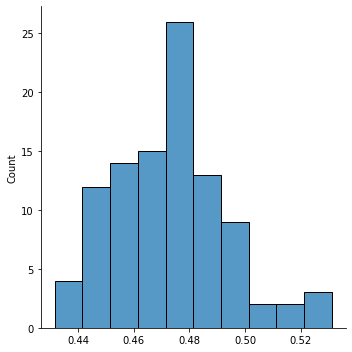

In [ ]:
sns.displot(data=test_score_tac_rf_list)

In [ ]:
rf = RandomForestRegressor()

rf_tac,train_score_tac_rf,test_score_tac_rf = model_scorer(rf)

rf_bat,train_score_bat_rf,test_score_bat_rf = model_scorer(rf,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)

In [ ]:
test_score_tac_rf

0.41406238606340817

In [ ]:
test_score_bat_rf

0.6114562920234464

In [ ]:
test_score_tac_bag_list = []
train_score_tac_bag_list =[]

for x in range(100):
    
    X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.1)

    X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.1)

    bag = BaggingRegressor()

    bag_tac,train_score_tac_bag,test_score_tac_bag = model_scorer(bag)

    bag_bat,train_score_bat_bag,test_score_bat_bag = model_scorer(bag,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)
    
    test_score_tac_bag_list.append(test_score_tac_bag)
    train_score_tac_bag_list.append(train_score_tac_bag)

avg_bag_tac_test = mean(test_score_tac_bag_list)
avg_bag_tac_train = mean(train_score_tac_bag_list)

if avg_bag_tac_test >= 0:
  test_score_average_tac_list.append(avg_bag_tac_test)

if avg_bag_tac_train >=0:
  train_score_average_tac_list.append(avg_bag_tac_train)


In [ ]:
print(avg_bag_tac_test)

0.36423736148848407


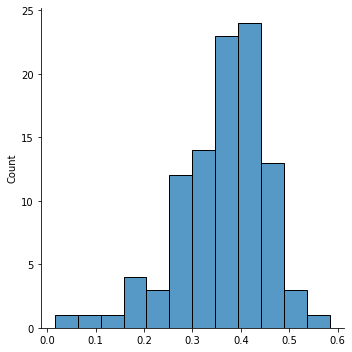

In [ ]:
sns.displot(data=test_score_tac_bag_list)

In [ ]:
test_score_tac_bag

0.4311080881390662

In [ ]:
test_score_bat_bag

0.7436234647728075

In [ ]:
test_score_tac_gb_list = []
train_score_tac_gb_list = []


for x in range(100):
    
    X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.1)

    X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.1)

    gb = GradientBoostingRegressor()

    gb_tac,train_score_tac_gb,test_score_tac_gb = model_scorer(gb)

    gb_bat,train_score_bat_gb,test_score_bat_gb = model_scorer(gb,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)
    
    test_score_tac_gb_list.append(test_score_tac_gb)
    train_score_tac_gb_list.append(train_score_tac_gb)
    
    print('train',train_score_tac_gb)
    print('test',test_score_tac_gb)
    
avg_gb_tac_test = mean(test_score_tac_gb_list)
avg_gb_tac_train = mean(train_score_tac_gb_list)

if avg_gb_tac_test >= 0:
  print('avg_gb_tac_test',avg_gb_tac_test)
  test_score_average_tac_list.append(avg_gb_tac_test)

if avg_gb_tac_train >=0:
  print('avg_gb_tac_train')
  train_score_average_tac_list.append(avg_gb_tac_train)



train 0.9937668773376553
test 0.3739790433796355
train 0.9937668773376553
test 0.377730042154218
train 0.9937668773376553
test 0.3848352155965299
train 0.9937668773376553
test 0.3809052973027671
train 0.9937668773376553
test 0.37885262688247767
train 0.9937668773376553
test 0.373277266295884
train 0.9937668773376553
test 0.37536165133245036
train 0.9937668773376553
test 0.38177460259816254
train 0.9937668773376553
test 0.3839498449081199
train 0.9937668773376553
test 0.3728783222305043
train 0.9937668773376553
test 0.37487872845284065
train 0.9937668773376553
test 0.3682009590080634
train 0.9937668773376553
test 0.38517875098594767
train 0.9937668773376553
test 0.37372666126362464
train 0.9937668773376553
test 0.3808049521983654
train 0.9937668773376553
test 0.3869359693746317
train 0.9937668773376553
test 0.38505643254318844
train 0.9937668773376553
test 0.38579950814826114
train 0.9937668773376553
test 0.3850217483058077
train 0.9937668773376553
test 0.3871504374627265
train 0.993766

In [ ]:
test_score_tac_gb

0.3797710818205602

In [ ]:
test_score_bat_gb

0.8860654930340401

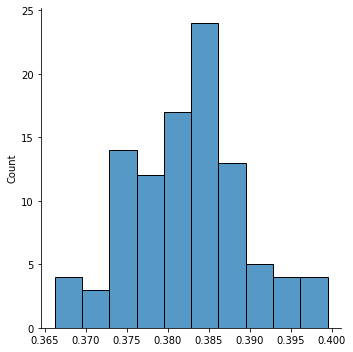

In [ ]:
sns.displot(data=test_score_tac_gb_list)

In [ ]:
nsvr = NuSVR()

nsvr_tac,train_score_tac_nsvr,test_score_tac_nsvr = model_scorer(nsvr)

nsvr_bat,train_score_bat_nsvr,test_score_bat_nsvr = model_scorer(nsvr,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)

In [ ]:
test_score_bat_nsvr

-0.01295570458292361

In [ ]:
test_score_tac_nsvr

-0.5171689027319861

In [ ]:
test_score_average_tac_list

[0.4732854274460864, 0.36423736148848407, 0.38241835704808386]

In [ ]:
test_score_average_tac_list[0]

0.4732854274460864

In [ ]:
train_score_average_tac_list

[0.8779509621785527, 0.9467591982790341, 0.9937668773376553]

In [ ]:
test_score_tac_mean = mean(test_score_average_tac_list)
print (test_score_tac_mean)

0.4066470486608848


In [ ]:
train_score_tac_mean = mean(train_score_average_tac_list)
print (train_score_tac_mean)

0.9394923459317474


#error analysis

In [ ]:
X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.1)

In [ ]:
std_scaler_tac = StandardScaler().fit(X_train_tac)

X_train_tac = std_scaler_tac.transform(X_train_tac)
X_test_tac = std_scaler_tac.transform(X_test_tac)


In [ ]:
rf = RandomForestRegressor().fit(X_train_tac,Y_train_tac)
y_pred_tac_train = rf.predict(X_train_tac)
y_pred_tac_test = rf.predict(X_test_tac)

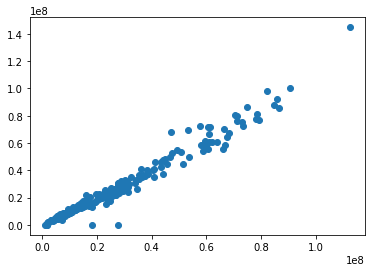

In [ ]:
plt.scatter(x=y_pred_tac_train,y=Y_train_tac)

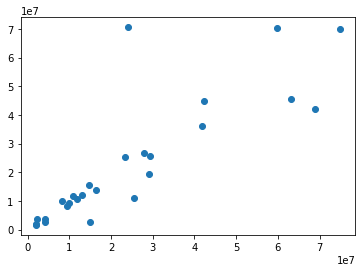

In [ ]:
plt.scatter(x=y_pred_tac_test,y=Y_test_tac)

In [ ]:
features = ['Hours_watched', 'Hours_Streamed', 'Peak_viewers', 'Peak_channels',
       'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio',
       'Counter-Strike: Global Offensive_web',
       'Tom Clancy\'s Rainbow Six Siege_web', 'Overwatch_web', 'Valorant_web',
       'Call of Duty: Modern Warfare_web',
       'Counter-Strike: Global Offensive_YT',
       'Tom Clancy\'s Rainbow Six Siege_YT', 'Overwatch_YT', 'Valorant_YT',
       'Call of Duty: Modern Warfare_YT',
       'Tac_tournament_Counter-Strike Global Offensive',
       'Tac_tournament_Tom Clancy\'s Rainbow Six Siege',
       'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
       'Tac_tournament_Call Of Duty Modern Warfare', 'Pub_Activision',
       'Pub_Blizzard', 'Pub_Riot', 'Pub_Ubisoft', 'Pub_Valve']

target = 'Hours_watched_target'

X_train_tac = pd.DataFrame(X_train_tac,columns=features)

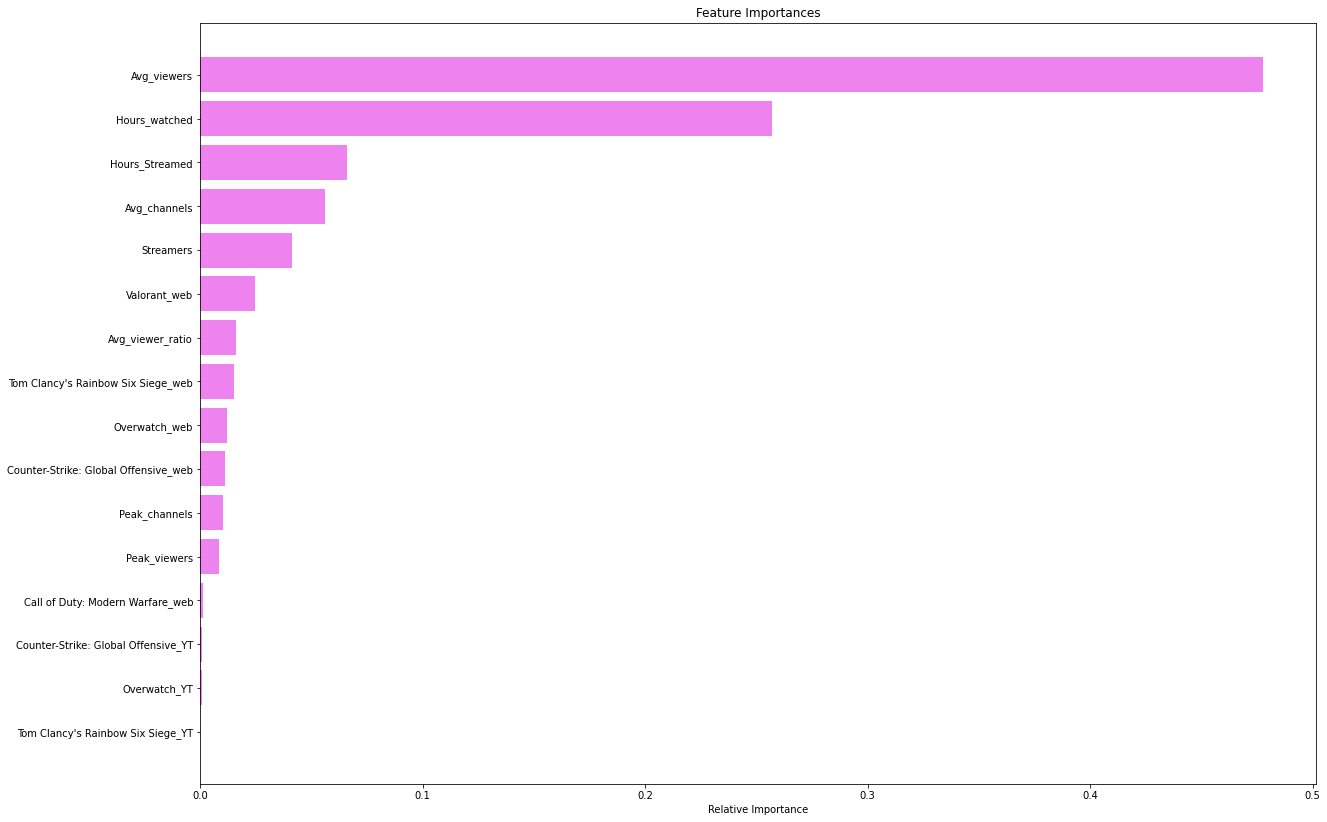

In [ ]:
importances = rf_tac.feature_importances_
indices = np.argsort(importances)
features = features_Tactical


plt.figure(figsize=(20,14))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
# features = ['Hours_watched', 'Hours_Streamed', 'Peak_viewers', 'Peak_channels',
#        'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio',
#        'Counter-Strike: Global Offensive_web',
#        'Tom Clancy\'s Rainbow Six Siege_web', 'Overwatch_web', 
#        'Valorant_web',
#        'Call of Duty: Modern Warfare_web',
#        'Counter-Strike: Global Offensive_YT',
#        'Tom Clancy\'s Rainbow Six Siege_YT', 'Overwatch_YT', 
#        'Valorant_YT',
#        'Call of Duty: Modern Warfare_YT',
#        'Tac_tournament_Counter-Strike Global Offensive',
#        'Tac_tournament_Tom Clancy\'s Rainbow Six Siege',
#        'Tac_tournament_Overwatch', 'Tac_tournament_VALORANT',
#        'Tac_tournament_Call Of Duty Modern Warfare', 'Pub_Activision',
#        'Pub_Blizzard', 'Pub_Riot', 'Pub_Ubisoft',
#       'Pub_Valve']

In [ ]:
def shap_summary_plot(df, features=features,target=target, test_size=.15,show=False):
  X = df[features]
  y = df[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  std_scaler = StandardScaler().fit(X_train)
  X_train = std_scaler.transform(X_train)
  X_test = std_scaler.transform(X_test)
  X_train = pd.DataFrame(X_train, columns=X.columns)
  X_test = pd.DataFrame(X_test, columns=X.columns)

  X_train_summary = shap.kmeans(X_train, 10)

  pca = PCA()
  model = RandomForestRegressor(max_depth=4,min_samples_split=5,max_features=0.8,max_samples=0.8,min_impurity_decrease=0.0015)
  pipe = make_pipeline(pca, model).fit(X_train,y_train)

  ex = shap.KernelExplainer(pipe.predict, X_train_summary)
  shap_values = ex.shap_values(X_test)

  #shap.initjs()

  print('test_score: {}'.format(pipe.score(X_test, y_test)))

  return shap.summary_plot(shap_values, X_test)

#shapley values


  0%|          | 0/38 [00:00<?, ?it/s]

test_score: 0.789494847802004


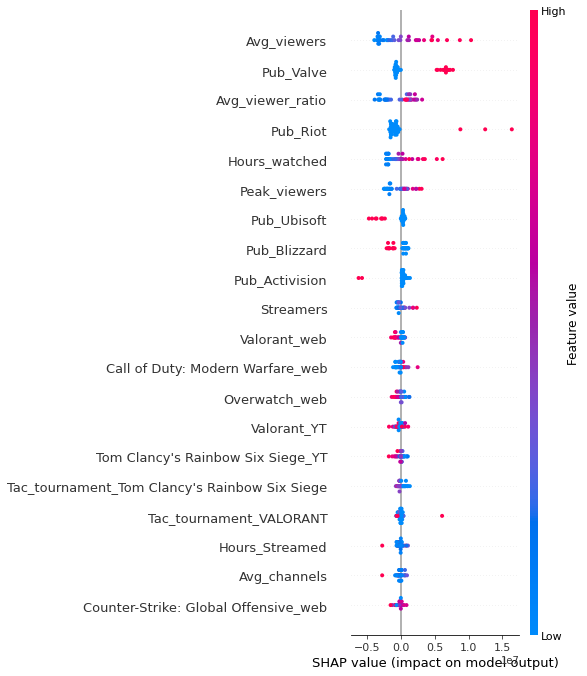

  0%|          | 0/38 [00:00<?, ?it/s]

test_score: 0.5154910215597843


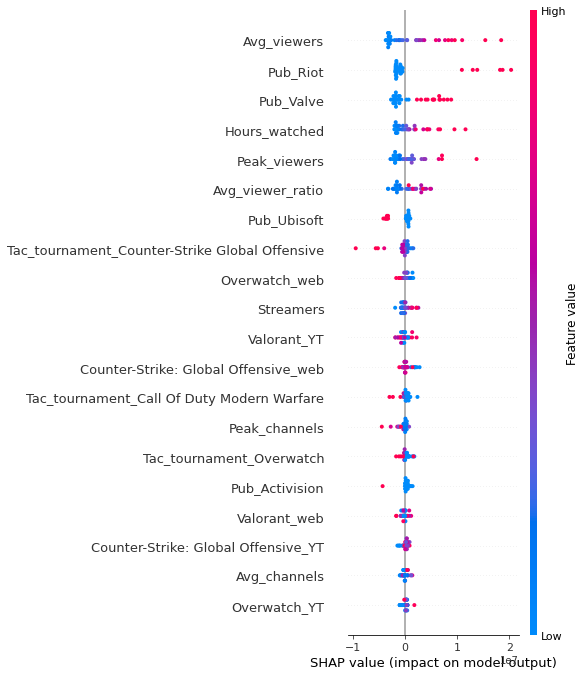

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range (2):
  shap_summary_plot(df_Tactical,features = features_Tactical, target = target_Tactical)
  plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/shapscores/shapscores{i}.png')

In [ ]:
#max_depth=3,min_samples_split=12,max_features=0.8,max_samples=0.8,min_impurity_decrease=0.002

In [ ]:
def model_test(tests,iterations):

  average_test_score_iterations = []
  average_train_score_iterations = []

  for x in range(tests):

    test_score_tac_rf_list = []
    train_score_tac_rf_list =[]

    X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_tac,Y_tac,test_size=.2)

    X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_bat,Y_bat,test_size=.2)

    for y in range(iterations):
      
      X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = train_test_split(X_train_tac,Y_train_tac,test_size=.1)

      X_train_bat, X_test_bat, Y_train_bat, Y_test_bat = train_test_split(X_train_bat,Y_train_bat,test_size=.1)
      
      rf = RandomForestRegressor(min_impurity_decrease=0.002,min_samples_split=15)

      rf_tac,train_score_tac_rf,test_score_tac_rf = model_scorer(rf)

      rf_bat,train_score_bat_rf,test_score_bat_rf = model_scorer(rf,X_train = X_train_bat, Y_train = Y_train_bat,X_test = X_test_bat, Y_test = Y_test_bat)
      
      print('train','test:',x, 'score:', train_score_tac_rf)
      print('test','test:',x, 'score:',test_score_tac_rf)
      
      train_score_tac_rf_list.append(train_score_tac_rf)
      test_score_tac_rf_list.append(test_score_tac_rf)
      
    print(test_score_tac_rf_list)
    avg_rf_tac_test = mean(test_score_tac_rf_list)
    avg_rf_tac_train = mean(train_score_tac_rf_list)
    print(avg_rf_tac_test)
          
    average_test_score_iterations.append(avg_rf_tac_test)
    average_train_score_iterations.append(avg_rf_tac_train)

  return average_test_score_iterations



In [ ]:
#rf_average_test_iterations = mean(model_test(5,30))
test_scores = model_test(3,10)
print(test_scores)
#print('average rf',rf_average_test_iterations)

train test: 0 score: 0.897485928556797
test test: 0 score: 0.3844049732674065
train test: 0 score: 0.8977573715690252
test test: 0 score: 0.4159157163018363
train test: 0 score: 0.895200585452456
test test: 0 score: 0.40140655106492806
train test: 0 score: 0.893592881070399
test test: 0 score: 0.4163028340345373
train test: 0 score: 0.8914193344281252
test test: 0 score: 0.37657305229078963
train test: 0 score: 0.8930640905606884
test test: 0 score: 0.37536904705583685
train test: 0 score: 0.8980464789898357
test test: 0 score: 0.41375459599414055
train test: 0 score: 0.9056966432076426
test test: 0 score: 0.46061716675525255
train test: 0 score: 0.8975326413349243
test test: 0 score: 0.411036709258237
train test: 0 score: 0.8990511858168115
test test: 0 score: 0.39511797980321817
[0.3844049732674065, 0.4159157163018363, 0.40140655106492806, 0.4163028340345373, 0.37657305229078963, 0.37536904705583685, 0.41375459599414055, 0.46061716675525255, 0.411036709258237, 0.39511797980321817]
0.

# Prediction

In [ ]:
X_tac.iloc[-4:]

Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                
2021_12    Blizzard       8003500.0        477729.0       55187.0   
           Riot          98306478.0       2812461.0     1047665.0   
           Ubisoft        7688187.0        567817.0       54163.0   
           Valve         45401155.0        914766.0      524450.0   

                      Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                        
2021_12    Blizzard          1087.0    50636.0      10771.0         642.0   
           Riot              6019.0   249067.0     132310.0        3785.0   
           Ubisoft           1586.0    69242.0      10347.0         764.0   
           Valve             2485.0    94162.0      61105.0        1231.0   

                      Avg_viewer_ratio  Counter-Strike: Global Offensive_web  \
Year_Month Publisher                                                           
2021_12    Blizzard              16.75                                  40.0   
           Riot                  34.95                                  40.0   
           Ubisoft               13.54                                  40.0   
           Valve                 49.63                                  40.0   

                      Tom Clancy's Rainbow Six Siege_web  ...  \
Year_Month Publisher                                      ...   
2021_12    Blizzard                                 18.0  ...   
           Riot                                     18.0  ...   
           Ubisoft                                  18.0  ...   
           Valve                                    18.0  ...   

                      Tac_tournament_Counter-Strike Global Offensive  \
Year_Month Publisher                                                   
2021_12    Blizzard                                              2.0   
           Riot                                                  2.0   
           Ubisoft                                               2.0   
           Valve                                                 2.0   

                      Tac_tournament_Tom Clancy's Rainbow Six Siege  \
Year_Month Publisher                                                  
2021_12    Blizzard                                             0.0   
           Riot                                                 0.0   
           Ubisoft                                              0.0   
           Valve                                                0.0   

                      Tac_tournament_Overwatch  Tac_tournament_VALORANT  \
Year_Month Publisher                                                      
2021_12    Blizzard                        0.0                      1.0   
           Riot                            0.0                      1.0   
           Ubisoft                         0.0                      1.0   
           Valve                           0.0                      1.0   

                      Tac_tournament_Call Of Duty Modern Warfare  \
Year_Month Publisher                                               
2021_12    Blizzard                                          0.0   
           Riot                                              0.0   
           Ubisoft                                           0.0   
           Valve                                             0.0   

                      Pub_Activision  Pub_Blizzard  Pub_Riot  Pub_Ubisoft  \
Year_Month Publisher                                                        
2021_12    Blizzard                0             1         0            0   
           Riot                    0             0         1            0   
           Ubisoft                 0             0         0            1   
           Valve                   0             0         0            0   

                      Pub_Valve  
Year_Month Publisher             
2021_12    Blizzard  

In [ ]:
X_train_tac, X_test_tac, Y_train_tac, Y_test_tac = X_tac.iloc[:-3],X_tac.iloc[-3],Y_tac.iloc[:-3],Y_tac.iloc[-3]

In [ ]:
gb = GradientBoostingRegressor().fit(X_train_tac,Y_train_tac)

In [ ]:
Y_predict = gb.predict(X_test_tac.values.reshape(1,-1))
Y_predict

array([74684072.16048366])

In [ ]:
df_Tactical

Rank  Hours_watched  Hours_Streamed  Peak_viewers  \
Year_Month Publisher                                                       
2016_01    Ubisoft     16.0      4866039.0        242134.0       25742.0   
           Valve        2.0     47832863.0        830105.0      372654.0   
2016_02    Blizzard    13.0      4735263.0         68029.0       94851.0   
           Ubisoft     18.0      3237323.0        219127.0       28240.0   
           Valve        2.0     44933218.0        754901.0      235027.0   
...                     ...            ...             ...           ...   
2021_12    Activision  71.0      3139259.0       1612383.0       33616.0   
           Blizzard    34.0      8003500.0        477729.0       55187.0   
           Riot         3.0     98306478.0       2812461.0     1047665.0   
           Ubisoft     36.0      7688187.0        567817.0       54163.0   
           Valve       10.0     45401155.0        914766.0      524450.0   

                       Peak_channels  Streamers  Avg_viewers  Avg_channels  \
Year_Month Publisher                                                         
2016_01    Ubisoft             694.0    42244.0       6549.0         325.0   
           Valve              2197.0   120849.0      64378.0        1117.0   
2016_02    Blizzard            546.0     7075.0       6813.0          97.0   
           Ubisoft             628.0    36759.0       4658.0         315.0   
           Valve              2097.0   106074.0      64652.0        1086.0   
...                              ...        ...          ...           ...   
2021_12    Activision         5541.0   138571.0       4225.0        2170.0   
           Blizzard           1087.0    50636.0      10771.0         642.0   
           Riot               6019.0   249067.0     132310.0        3785.0   
           Ubisoft            1586.0    69242.0      10347.0         764.0   
           Valve              2485.0    94162.0      61105.0        1231.0   

                       Avg_viewer_ratio  Hours_watched_target_1  ...  \
Year_Month Publisher                                             ...   
2016_01    Ubisoft                20.10               3237323.0  ...   
           Valve                  57.62              44933218.0  ...   
2016_02    Blizzard               69.61               2735563.0  ...   
           Ubisoft                14.77               1912821.0  ...   
           Valve                  59.52              71963213.0  ...   
...                                 ...                     ...  ...   
2021_12    Activision              1.95                     0.0  ...   
           Blizzard               16.75                     0.0  ...   
           Riot                   34.95                     0.0  ...   
           Ubisoft                13.54                     0.0  ...   
           Valve                  49.63                     0.0  ...   

                       Tac_tournament_Counter-Strike Global Offensive  \
Year_Month Publisher                                                    
2016_01    Ubisoft                                                0.0   
           Valve                                                  0.0   
2016_02    Blizzard                                               0.0   
           Ubisoft                                                0.0   
           Valve                                                  0.0   
...                                                               ...   
2021_12    Activision                                             2.0   
           Blizzard                                               2.0   
           Riot                                                   2.0   
           Ubisoft                                                2.0   
           Valve                                                  2.0   

                       Tac_tournament_Tom Clancy's Rainbow Six Siege  \
Year_Month Publisher                                        

In [ ]:
df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Valve']

,,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Hours_watched_target_1,...,Tac_tournament_Counter-Strike Global Offensive,Tac_tournament_Tom Clancy's Rainbow Six Siege,Tac_tournament_Overwatch,Tac_tournament_VALORANT,Tac_tournament_Call Of Duty Modern Warfare,Pub_Activision,Pub_Blizzard,Pub_Riot,Pub_Ubisoft,Pub_Valve
Year_Month,Publisher,,,,,,,,,,,,,,,,,,,,,
2021_03,Valve,8.0,72375036.0,1626300.0,454393.0,4379.0,170319.0,97409.0,2188.0,44.50,70072819.0,...,1.0,0.0,0.0,3.0,1.0,0,0,0,0,1
2021_04,Valve,8.0,70072819.0,1464933.0,421485.0,4173.0,158206.0,97458.0,2037.0,47.83,75670449.0,...,3.0,5.0,1.0,3.0,1.0,0,0,0,0,1
2021_05,Valve,8.0,75670449.0,1380646.0,551182.0,3620.0,140856.0,101844.0,1858.0,54.81,55332904.0,...,3.0,1.0,2.0,1.0,3.0,0,0,0,0,1
2021_06,Valve,9.0,55332904.0,1162096.0,363798.0,2995.0,116511.0,76958.0,1616.0,47.61,58658860.0,...,5.0,0.0,2.0,0.0,2.0,0,0,0,0,1
2021_07,Valve,7.0,58658860.0,1107453.0,696447.0,2513.0,112617.0,78948.0,1490.0,52.97,49822431.0,...,1.0,6.0,1.0,3.0,1.0,0,0,0,0,1
2021_08,Valve,9.0,49822431.0,1099409.0,378388.0,2538.0,114949.0,67055.0,1479.0,45.32,61533744.0,...,1.0,1.0,0.0,4.0,1.0,0,0,0,0,1
2021_09,Valve,7.0,61533744.0,1007538.0,725327.0,2823.0,105073.0,85582.0,1401.0,61.07,70180423.0,...,2.0,1.0,1.0,1.0,0.0,0,0,0,0,1
2021_10,Valve,6.0,70180423.0,956368.0,655467.0,2555.0,97136.0,94455.0,1287.0,73.38,79981393.0,...,3.0,3.0,0.0,3.0,0.0,0,0,0,0,1
2021_11,Valve,4.0,79981393.0,951598.0,1916027.0,2590.0,97574.0,111239.0,1323.0,84.05,45401155.0,...,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1


In [ ]:
target_Tactical

['Hours_watched_target_1']

In [ ]:
df_predict = pd.DataFrame(columns=target_Tactical)
dict_pred = {}

In [ ]:
target_list = ['Hours_watched_target_1',
               'Hours_watched_target_2',
               'Hours_watched_target_3',
               'Hours_watched_target_4',
               'Hours_watched_target_5',
               'Hours_watched_target_6']


In [ ]:
Month_Year = df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Valve'].index.get_level_values('Year_Month')
Month_Year

Index(['2021_03', '2021_04', '2021_05', '2021_06', '2021_07', '2021_08',
       '2021_09', '2021_10', '2021_11', '2021_12'],
      dtype='object', name='Year_Month')

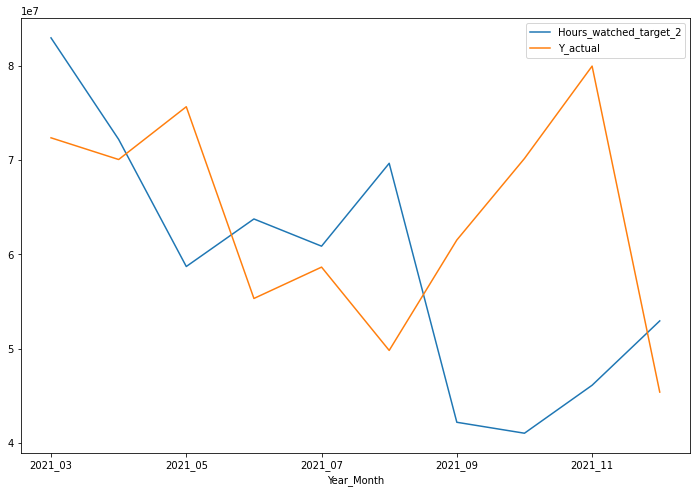

In [ ]:
#assigning x features

X_tac = df_Tactical[features_Tactical].iloc[:204]

#assigning y target


#double loop for looping 6 month of predictions and publishers

for target in target_list:
  Y_tac = df_Tactical[target].iloc[:204]
  X_tac_test = df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Valve'][features_Tactical]
  Month_Year = df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Valve'].index.get_level_values('Year_Month')
  Y_actual = df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Valve']['Hours_watched']
  gb = GradientBoostingRegressor().fit(X_tac,Y_tac)
  Y_pred = list(gb.predict(X_tac_test))
  dict_pred[f'{target}'] = Y_pred
  

df = pd.DataFrame(dict_pred,index=Month_Year)
df=df.reindex(columns=target_list)
df['Y_actual'] = Y_actual.values

df[['Hours_watched_target_2','Y_actual']].plot(figsize=(12,8))

df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Esports analytics tool/predictions.csv')

In [ ]:
  # #assigning x features

# X_tac = df_Tactical[features_Tactical].iloc[:204]

# #assigning y target
# Y_tac = df_Tactical[target_Tactical].iloc[:204]

# X_tac_test = df_Tactical.iloc[204:].iloc[df_Tactical.iloc[204:].index.get_level_values('Publisher')=='Riot'][features_Tactical]

# gb = GradientBoostingRegressor().fit(X_tac,Y_tac)

# Y_pred = list(gb.predict(X_tac_test))

# dict_pred = {f'{target_Tactical[0]}':Y_pred}
# pd.DataFrame(dict_pred)

In [ ]:
Y_actual

Year_Month  Publisher
2021_03     Valve        72375036.0
2021_04     Valve        70072819.0
2021_05     Valve        75670449.0
2021_06     Valve        55332904.0
2021_07     Valve        58658860.0
2021_08     Valve        49822431.0
2021_09     Valve        61533744.0
2021_10     Valve        70180423.0
2021_11     Valve        79981393.0
2021_12     Valve        45401155.0
Name: Hours_watched, dtype: float64

NameError: ignored